# Hadamard Test vs. Quantum Phase Estimation

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
token = input('Enter IBM API token: ')

from qiskit_aer.noise import NoiseModel
# change this to what you have access to
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='rpi-rensselaer/research/faulsf',
    token=token
)
rpi = service.backend("ibm_rensselaer")
sim = AerSimulator()

use_real_hardware = True

## Table of Contents

* [Introduction](#Introduction)
* [Hadamard Test Data Generation](#Hadamard-Test-Data-Generation)
* [Quantum Phase Estimation Data Generation](#Quantum-Phase-Estimation-Data-Generation)
* [Comparison of HT and QPE](#Comparison)

## Introduction

The Hadamard Test (HT) and Quantum Phase Estimation (QPE) both serve to estimate the phase $\varphi$ in an eigenvalue of the form $e^{i2\pi\varphi}$ of a unitary operator $U$. In this section, we compare the two algorithms with respect to accuracy and runtime, using both classical simulations and real quantum hardware (IBM Eagle One system at RPI, known as $\texttt{ibm\_rensselaer}$).

To ensure a fair comparison, both algorithms are used to estimate the same eigenphase $\varphi = 1/3$ of the unitary matrix
$$U = \begin{pmatrix}
    1 & 0 \\
    0 & e^{i2\pi\varphi}
\end{pmatrix},$$
to precision $\epsilon$. To extract the value $\varphi$ using HT, the estimate is simply divided by $2\pi$. 


A direct comparison of the error between the Hadamard Test (HT) and Quantum Phase Estimation (QPE) is nontrivial due to the fundamentally different nature of their errors: HT exhibits sampling error, while QPE exhibits approximation error based on binary resolution. To visualize the convergence behavior of each algorithm as a function of its quantum resources, we plot their respective errors on a shared graph. The run time of each algorithm is also estimated and plotted in a joint graph to observe how it scales for the respective algorithms per their allocated quantum resource. For this comparison, we run each algorithm over $20$ independent trials. The HT is tested with shot counts ranging from $10^3$ to $10^5$, while QPE is tested using $1$ to $20$ ancilla qubits, each run with $1000$ shots. All experiments were conducted both on Qiskit's AerSimulator and on $\texttt{ibm\_rensselaer}$, an IBM Quantum System One Eagle processor. These parameters were selected to span a realistic range of quantum resources given current simulation and hardware constraints.



In [2]:
varphi = 1/3 # Exact value of varphi to estimate for this example

varphi = varphi%(1)
angle  = varphi*2*pi
print("varphi:\t\t", varphi)
print("phase angle:\t", angle, "rad")

varphi:		 0.3333333333333333
phase angle:	 2.0943951023931953 rad


## Hadamard Test Data Generation

First, the Hadamard test is run on the AerSimulator as before, but with the unitary $U$ above, estimating $\varphi$.

In [3]:
def create_HT(theta, test, device):
    circuit = QuantumCircuit(2,1)
    circuit.x(1)
    circuit.h(0)
    if test == 'Im': circuit.sdg(0)
    circuit.cp(theta,0,1) 
    circuit.h(0) 
    circuit.measure(0,0)
    tcircuit = transpile(circuit, backend = device, optimization_level = 3)
    return tcircuit

We now cycle through $10^3 - 10^5$ shots appending the error and run time of each trial to a list to plot the error convergence and run time as the shots increase on the simulation.

In [4]:
# Calculate the simulated runtime and error
backend = sim
sampler = Sampler(backend)
trials = [int(shots) for shots in np.logspace(3, 5, 20)] # shots needs to be an integer
HT_sim_runtime = []
HT_sim_error = []
for num_shots in trials:
    total_time = 0
    transRe = create_HT(angle, 'Re', backend)
    job = sampler.run([transRe], shots = num_shots)
    start = time.time()
    resultRe = job.result()[0]
    end = time.time()
    total_time += end-start
    countsRe = resultRe.data.c.get_counts()

    transIm = create_HT(angle, 'Im', backend)
    job = sampler.run([transIm], shots = num_shots)
    start = time.time()
    resultIm = job.result()[0]
    end = time.time()
    total_time += end-start
    countsIm = resultIm.data.c.get_counts()

    HT_sim_runtime.append(total_time)
    
    re_p0 = im_p0 = 0
    if countsRe.get('0') is not None:
        re_p0 = countsRe['0']/num_shots
    if countsIm.get('0') is not None:
        im_p0 = countsIm['0']/num_shots

    # compute monte-carlo error
    HT_sim_error.append((re_p0*(1 - re_p0)/num_shots)**(0.5))
    print(f'Trial for {num_shots} shots is done')
print('All trials completed')

Trial for 1000 shots is done
Trial for 1274 shots is done
Trial for 1623 shots is done
Trial for 2069 shots is done
Trial for 2636 shots is done
Trial for 3359 shots is done
Trial for 4281 shots is done
Trial for 5455 shots is done
Trial for 6951 shots is done
Trial for 8858 shots is done
Trial for 11288 shots is done
Trial for 14384 shots is done
Trial for 18329 shots is done
Trial for 23357 shots is done
Trial for 29763 shots is done
Trial for 37926 shots is done
Trial for 48329 shots is done
Trial for 61584 shots is done
Trial for 78475 shots is done
Trial for 100000 shots is done
All trials completed


We repeat the same process on real quantum hardware.

In [5]:
backend = rpi
if not use_real_hardware: backend = AerSimulator(noise_model=NoiseModel.from_backend(backend))
sampler = Sampler(backend)
trials = [int(shots) for shots in np.logspace(3, 5, 20)]
HT_hardware_runtimes = []
HT_hardware_error = []
for num_shots in trials:
    total_time = 0
    transRe = create_HT(angle, 'Re', backend)
    job = sampler.run([transRe], shots = num_shots)
    if not use_real_hardware: start = time.time()
    resultRe = job.result()[0]
    if not use_real_hardware:
        end = time.time()
        total_time += end-start
    else:
        total_time += job.metrics()['usage']['quantum_seconds']
    countsRe = resultRe.data.c.get_counts()

    transIm = create_HT(angle, 'Im', backend)
    job = sampler.run([transIm], shots = num_shots)
    if not use_real_hardware: start = time.time()
    resultRe = job.result()[0]
    if not use_real_hardware:
        end = time.time()
        total_time += end-start
    else:
        total_time += job.metrics()['usage']['quantum_seconds']
    countsIm = resultIm.data.c.get_counts()

    HT_hardware_runtimes.append(total_time)
    
    re_p0 = im_p0 = 0
    if countsRe.get('0') is not None:
        re_p0 = countsRbe['0']/num_shots
    if countsIm.get('0') is not None:
        im_p0 = countsIm['0']/num_shots

    # compute monte-carlo error
    HT_hardware_error.append((re_p0*(1 - re_p0)/num_shots)**(0.5))
    print(f'Trial for {num_shots} shots is done')
print('All trials completed')

Trial for 1000 shots is done
Trial for 1274 shots is done
Trial for 1623 shots is done
Trial for 2069 shots is done
Trial for 2636 shots is done
Trial for 3359 shots is done
Trial for 4281 shots is done
Trial for 5455 shots is done
Trial for 6951 shots is done
Trial for 8858 shots is done
Trial for 11288 shots is done
Trial for 14384 shots is done
Trial for 18329 shots is done
Trial for 23357 shots is done
Trial for 29763 shots is done
Trial for 37926 shots is done
Trial for 48329 shots is done
Trial for 61584 shots is done
Trial for 78475 shots is done
Trial for 100000 shots is done
All trials completed


## Quantum Phase Estimation Data Generation

Now the quantum phase estimation algorithm is run on the simulation for the unitary $U$ estimating $\varphi$.

In [6]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.measure(i,i)

def QPE(ancilla_bits, varphi, device, opt = 3):
    qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
    setup(qc, ancilla_bits)
    qc.x(ancilla_bits)
    qc.barrier()
    for i in range(ancilla_bits):
        qc.cp((2*pi*varphi)*2**(i), ancilla_bits,i)
    add_inv_fourier_transform(qc,ancilla_bits)
    measure(qc, ancilla_bits)
    tqc = transpile(qc, backend = device, optimization_level = opt)
    return tqc

We now cycle through $1 - 20$ ancillas appending the error and run time of each trial to a list to plot the error convergence and run time as the qubits increase on the simulation.

In [7]:
backend = sim
sampler = Sampler(backend)
anc_bits = np.arange(1,21,1)
QPE_sim_runtimes = []
QPE_sim_error = []
for bits in anc_bits:
    tqc = QPE(bits, varphi, backend)
    job = sampler.run([tqc], shots=1000)
    start = time.time()
    result = job.result()[0]
    end = time.time()
    counts = result.data.c.get_counts()
    QPE_sim_runtimes.append(end-start)

    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    QPE_sim_error.append(abs(angle - 2*pi*decimal_num))
    print(f'Trial for {bits} ancilla bits is done')
print('All trials completed')

Trial for 1 ancilla bits is done
Trial for 2 ancilla bits is done
Trial for 3 ancilla bits is done
Trial for 4 ancilla bits is done
Trial for 5 ancilla bits is done
Trial for 6 ancilla bits is done
Trial for 7 ancilla bits is done
Trial for 8 ancilla bits is done
Trial for 9 ancilla bits is done
Trial for 10 ancilla bits is done
Trial for 11 ancilla bits is done
Trial for 12 ancilla bits is done
Trial for 13 ancilla bits is done
Trial for 14 ancilla bits is done
Trial for 15 ancilla bits is done
Trial for 16 ancilla bits is done
Trial for 17 ancilla bits is done
Trial for 18 ancilla bits is done
Trial for 19 ancilla bits is done
Trial for 20 ancilla bits is done
All trials completed


We repeat the same process on real quantum hardware.

In [8]:
backend = rpi
if not use_real_hardware: backend = AerSimulator(noise_model=NoiseModel.from_backend(backend))
sampler = Sampler(backend)
anc_bits = np.arange(1,21,1)
QPE_hardware_runtimes = []
QPE_hardware_error = []
for bits in anc_bits:
    tqc = QPE(bits, varphi, backend)
    job = sampler.run([tqc], shots=1000)
    if not use_real_hardware: start = time.time()
    result = job.result()[0]
    if not use_real_hardware:
        end = time.time()
        total_time = end-start
    else:
        total_time = job.metrics()['usage']['quantum_seconds']
    QPE_hardware_runtimes.append(total_time)
    counts = result.data.c.get_counts()
    
    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    QPE_hardware_error.append(abs(angle - 2*pi*decimal_num))
    print(f'Trial for {bits} ancilla bits is done')
print('All trials completed')

Trial for 1 ancilla bits is done
Trial for 2 ancilla bits is done
Trial for 3 ancilla bits is done
Trial for 4 ancilla bits is done
Trial for 5 ancilla bits is done
Trial for 6 ancilla bits is done
Trial for 7 ancilla bits is done
Trial for 8 ancilla bits is done
Trial for 9 ancilla bits is done
Trial for 10 ancilla bits is done
Trial for 11 ancilla bits is done
Trial for 12 ancilla bits is done
Trial for 13 ancilla bits is done
Trial for 14 ancilla bits is done
Trial for 15 ancilla bits is done
Trial for 16 ancilla bits is done
Trial for 17 ancilla bits is done
Trial for 18 ancilla bits is done
Trial for 19 ancilla bits is done
Trial for 20 ancilla bits is done
All trials completed


## Comparison

With the error convergence and run time for both algorithms, we can now compare the algorithms for the $20$ trials.

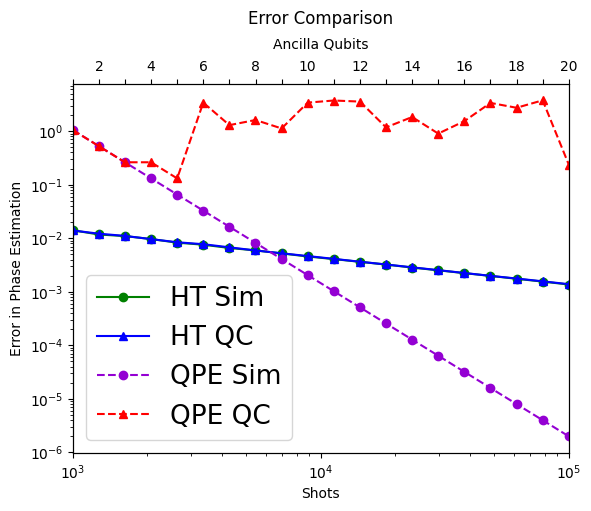

In [9]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials, HT_sim_error, 'go-', label='HT Sim')
lin2, = ax.loglog(trials, HT_hardware_error, 'b^-', label='HT QC')
lin3, = ax.loglog(trials, QPE_sim_error, 'darkviolet', marker='o', ls='--', label='QPE Sim')
lin4, = ax.loglog(trials, QPE_hardware_error, 'r^--', label='QPE QC')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

# y log-scale
nticks = 9
maj_loc = ticker.LogLocator(numticks=nticks)
min_loc = ticker.LogLocator(subs='all', numticks=nticks)
ax2.yaxis.set_major_locator(maj_loc)
ax2.yaxis.set_minor_locator(min_loc)

ax.set_xlabel("Shots")
ax.set_ylabel("Error in Phase Estimation")
plt.title('Error Comparison', pad = 10)
ax.legend(loc='lower left', fontsize=19)

plt.show()

As shown in the plot above, the Hadamard test (HT) exhibits excellent agreement between the observed and theoretically predicted error across all tested configurations, even when executed on real quantum hardware. In contrast, Quantum Phase Estimation (QPE) deviates significantly from theoretical predictions when the number of ancilla qubits exceeds $t=3$. For $t\leq 3$, QPE performs as expected, with error decreasing according to the predicted $\mathcal{O}(2^{-t})$ scaling. However, for $t>3$, the error no longer decreases and may even worsen with additional ancilla qubits.

This degradation is attributed to the growing circuit depth and gate count: Each added ancilla qubit introduces a new layer of controlled $U^{2^j}$ operations, many of which are decomposed into multiple two-qubit gates. On current noisy intermediate-scale quantum (NISQ) hardware, this increased gate complexity significantly amplifies noise and decoherence, undermining QPE's theoretical advantages. To reduce the impact of noise, we employed Qiskit’s transpiler with various $\texttt{optimization\_level}$ settings (0–3), which aim to simplify the circuit and reduce the total gate count. Although higher optimization levels (e.g., $\texttt{optimization\_level = 3}$) are effective at minimizing noise in many applications, in this experiment they were insufficient to recover QPE performance beyond $t=3$. This suggests that current hardware remains too noisy to realize the full potential of QPE in regimes that require deeper circuits.

In [10]:
anc_bit = np.arange(1,21,1)
depths = [[],[],[],[]]
for opt in range(4):
    for bit in anc_bit:
        tqc = QPE(bit, angle, rpi, opt=opt)
        filter = lambda x: x.operation.name == "ecr" # create a filter for the 2 qubit gates
        twodepth = tqc.depth(filter)
        depths[opt].append(twodepth)

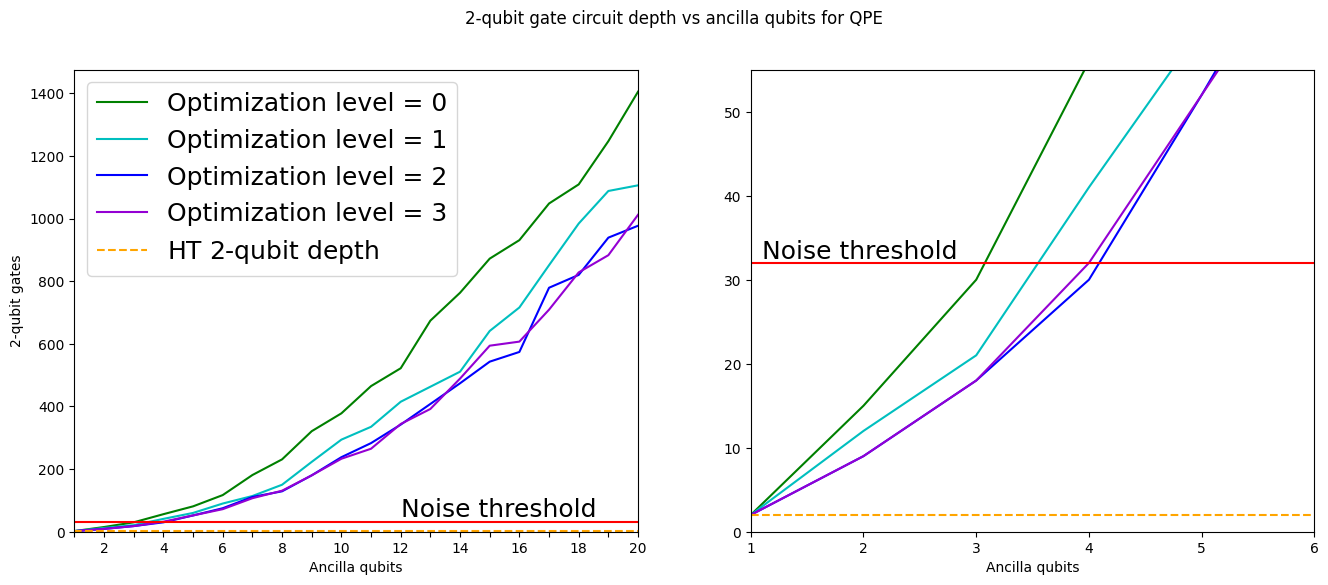

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot(anc_bit, depths[0], 'g', ls = '-', label = 'Optimization level = 0')
axes[0].plot(anc_bit, depths[1], 'c', ls = '-', label = 'Optimization level = 1')
axes[0].plot(anc_bit, depths[2], 'b', ls = '-', label = 'Optimization level = 2')
axes[0].plot(anc_bit, depths[3], 'darkviolet', ls = '-', label = 'Optimization level = 3')
axes[0].set_xticks(anc_bit)

for label in axes[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

val = str(depths[3][3])

axes[0].axhline(y=depths[3][3], color='r', linestyle='-')
axes[0].axhline(y=2, color='orange', linestyle='--', label = 'HT $2$-qubit depth')
axes[0].text(12, depths[3][3] + 15, "Noise threshold", fontsize = 18, color = 'k')
axes[0].set_ylim(0)
axes[0].set_xlim(1,20)

fig.suptitle('2-qubit gate circuit depth vs ancilla qubits for QPE')
axes[0].legend(loc='upper left', fontsize = 18)
axes[0].set_xlabel('Ancilla qubits')
axes[0].set_ylabel('2-qubit gates')

axes[1].set_xlabel('Ancilla qubits')

axes[1].plot(anc_bit, depths[0], 'g', ls = '-', label = 'Optimization level $= 0$')
axes[1].plot(anc_bit, depths[1], 'c', ls = '-', label = 'Optimization level $= 1$')
axes[1].plot(anc_bit, depths[2], 'b', ls = '-', label = 'Optimization level $= 2$')
axes[1].plot(anc_bit, depths[3], 'darkviolet', ls = '-', label = 'Optimization level $= 3$')
axes[1].set_xticks(anc_bit)

axes[1].axhline(y=depths[3][3], color='r', linestyle='-')
axes[1].axhline(y=2, color='orange', linestyle='--', label = 'HT depth')
axes[1].text(1.1, depths[3][3] + 0.5, "Noise threshold", fontsize = 18, color = 'k')
axes[1].set_ylim(0,55)
axes[1].set_xlim(1,6)

plt.show()
fig.tight_layout()

To better understand the performance degradation of QPE on hardware, it is useful to analyze the circuit depth, which serves as a proxy for accumulated gate noise and decoherence effects. While circuit depth captures the overall number of sequential operations, the primary contributors to hardware error are two-qubit gates, which are more error-prone than single-qubit gates and dominate the noise profile in most NISQ devices. As illustrated in the plot above, the number of two-qubit gates in QPE circuits grows rapidly with each additional ancilla qubit. Although Qiskit’s higher transpiler optimization levels ($2$ and $3$) significantly reduce this gate count compared to lower levels, the improvement is not sufficient beyond $t=3$. In particular, circuits for $t\geq 4$ remain too deep -- despite aggressive optimization -- to yield reliable output on current quantum hardware, underscoring the practical limitations of QPE in its standard form on today’s machines.

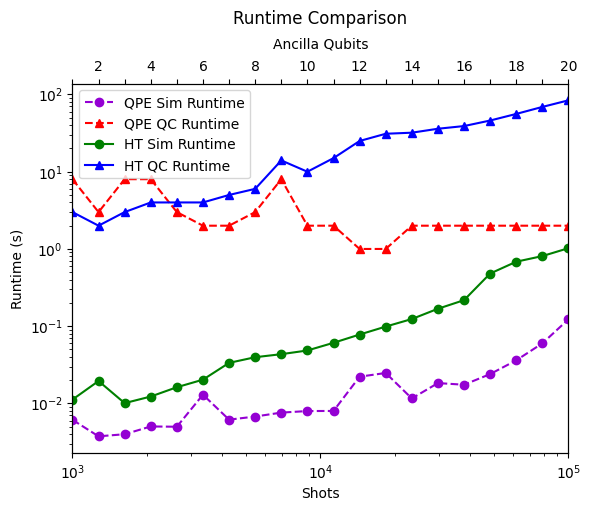

In [12]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials,QPE_sim_runtimes, color = 'darkviolet', marker ='o', ls = '--', label = 'QPE Sim Runtime')
lin2, = ax.loglog(trials,QPE_hardware_runtimes,'r^', ls = '--', label = 'QPE QC Runtime')
lin3, = ax.loglog(trials,HT_sim_runtime, 'go', ls = '-', label = 'HT Sim Runtime')
lin4, = ax.loglog(trials,HT_hardware_runtimes, 'b^', ls = '-', label = 'HT QC Runtime')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

ax.set_xlabel("Shots")
ax.set_ylabel("Runtime (s)")
plt.title('Runtime Comparison', pad = 10)

ax.legend()
plt.show()

Runtime is measured as the total execution time for a fixed accuracy target. Although HT and QPE have different resource requirements (shots vs. ancilla qubits), they share a dependence on the physical capabilities of the backend.


The plot above shows a runtime comparison of HT and QPE on a quantum emulator and an IBM Eagle 127-qubit quantum processor. For HT, the simulated experiment requires less runtime per shot compared to its quantum counterpart. Since the total runtime of HT scales directly with the runtime per shot, we observe that the runtime of HT on the quantum computer exhibits an offset, resulting in a runtime consistently higher than that of the quantum emulator. For QPE, the classical simulation runtime is initially lower than the runtime on the quantum computer but increases exponentially. On the quantum computer, the QPE runtime remains close to linear. For the tested system, we observe a likely crossing of the respective runtimes at some close trial out of our range. 


Note that for $t=1$ ancilla qubits, the QPE circuit is structurally equivalent to the real HT circuit. However, in practice, the total runtime of HT is observed to be approximately twice that of QPE at this setting. This discrepancy arises because HT requires two separate circuits -- one to estimate the real part and another to estimate the imaginary part of the expectation value -- in order to reconstruct the full complex phase. In contrast, QPE encodes the phase directly into a binary register, requiring only one circuit to extract the phase information. 

We emphasize that to increase the precision of the estimated phase on the quantum emulator, the runtime of both the HT and QPE will increase. However, on the quantum computer, regardless of the value of $t$, QPE's runtime remains nearly linear, while HT's runtime exponentially increases with the number of shots. 

Even with QPE's inaccuracy, its runtime is always very low on a quantum machine. Therefore, if the noise can somehow be mitigated better as the ancillary qubits increase, the QPE algorithm will become extremely effective in estimating phases with high binary bit precision. Since QPE is unreliable for binary representations of $d > 3$ bits, unless the phase can be exactly represented with $d\leq 3$ bits, the HT will give higher precision. Since HT is always slower than QPE, if the phase can be exactly represented with $d\leq 3$ bits, QPE will give higher precision and lower runtime.